# Assignment 6: Training Fully-connected Neural Networks and CNNs

In [1]:
# enter your name and UFL email address
name = 'enter your name'
email = 'enter your email'

name = 'solution' # ###- 
email = 'solution' # ###- 

In [2]:
if name == 'enter your name' or email == 'enter your email':
    assert False, 'Enter your name & email first!'
else:
    print('Assignment 6 -- name: {}, email: {}\n'.format(name, email))
    
    # Load packages we need
    import sys
    import os
    import time

    import numpy as np
    import sklearn
    
    # we'll use tensorflow and keras for neural networks
    import tensorflow as tf
    import tensorflow.keras as keras
    
    # Load the TensorBoard notebook extension
    #%load_ext tensorboard

    from matplotlib import pyplot as plt
    plt.rcParams.update({'font.size': 16})

    # Let's check our software versions
    print('### Python version: ' + __import__('sys').version)
    print('### NumPy version: ' + np.__version__)
    print('### Scikit-learn version: ' + sklearn.__version__)
    print('### Tensorflow version: ' + tf.__version__)
    print('### TF Keras version: ' + keras.__version__)
    print('------------')


    # load our packages / code
    sys.path.insert(1, '../common/')
    import utils
    import plots

Assignment 6 -- name: solution, email: solution

### Python version: 3.8.5 (default, Jan 27 2021, 15:41:15) 
[GCC 9.3.0]
### NumPy version: 1.19.5
### Scikit-learn version: 0.24.0
### Tensorflow version: 2.4.0
### TF Keras version: 2.4.0
------------


In [3]:
# global parameters to control behavior of the pre-processing, ML, analysis, etc.
seed = 42

# deterministic seed for reproducibility
np.random.seed(seed)
tf.random.set_seed(seed)

prop_vec = [24, 2, 2]

### For this assignment we'll use the MNIST dataset, which contains images of handwritten digits.
### The task is to predict what digit a given image contains

In [4]:
# grab the data
train_x, train_y, test_x, test_y, val_x, val_y, all_x, all_y = utils.load_preprocess_mnist_data(onehot=True, prop_vec=prop_vec, seed=seed)

# sanity check shapes
train_x.shape, train_y.shape, test_x.shape, test_y.shape, val_x.shape, val_y.shape

((60000, 784), (60000, 10), (5000, 784), (5000, 10), (5000, 784), (5000, 10))

## First, let's setup some performance evaluation and plotting code

In [5]:
# Let's create a custom callback class
class PerfEvalCustomCallback(keras.callbacks.Callback):
    
    def __init__(self, perf_data):
        self.perf_data = perf_data
    
    # we define the on_epoch_end callback and save the loss and accuracy in perf_data
    def on_epoch_end(self, epoch, logs=None):
        self.perf_data[epoch,0] = logs['loss']
        self.perf_data[epoch,1] = logs['accuracy']
        self.perf_data[epoch,2] = logs['val_loss']
        self.perf_data[epoch,3] = logs['val_accuracy']

    def get_perf_data():
        return self.perf_data

In [6]:
# Plot the model's performance during training (across epochs)
def plot_training_perf(train_loss, train_acc, val_loss, val_acc, fs=(8,5)):
    plt.figure(figsize=fs)


    assert train_loss.shape == val_loss.shape and train_loss.shape == val_acc.shape and val_acc.shape == train_acc.shape
    
    # assume we have one measurement per epoch
    num_epochs = train_loss.shape[0]
    epochs = np.arange(0, num_epochs)
    
    # Can you figure out why this makes sense? Why remove -0.5?
    plt.plot(epochs-0.5, train_loss, 'm', linewidth=2,  label='Loss (Training)')
    plt.plot(epochs-0.5, train_acc, 'r--', linewidth=2, label='Accuracy (Training)')
    
    plt.plot(epochs, val_loss, 'g', linewidth=2, label='Loss (Validation)')
    plt.plot(epochs, val_acc, 'b:', linewidth=2, label='Accuracy (Validation)')
    
    
    plt.xlim([0, num_epochs])
    plt.ylim([0, 1.05])
    
    plt.legend()
    
    plt.show()

## [Task 1] (10 points) Complete (& Customize) Your Model Training and Evaluation Code

### [Task 1a] (10 points) Complete the implementation of evaluate_model(). You can customize it to add whatever evaluation functionality you like (e.g., classification report, error analysis, etc.). Make sure you like the way it shows you the information: you will use it throughout this assignment!

In [7]:
# Customize this function as you like but makes sure it is implemented correctly.    
# Note: If you need to change the method definition to add more arguments, make sure to make 
# the new arguments are optional (& have a sensible default value)
def evaluate_model(name, model, eval_data, 
                   plot_training=True, evaluate_on_test_set=True):
    
    # unpack the stuff
    perf_data, dataset = eval_data
    train_x, train_y, val_x, val_y, test_x, test_y = dataset
    
    # get predictions from the model
    train_preds = model.predict(train_x)
    val_preds = model.predict(val_x)
    
    # measure the accuracy (as categorical accuracy since we have a softmax layer)
    catacc_metric = keras.metrics.CategoricalAccuracy()
    catacc_metric.update_state(train_y, train_preds)
    train_acc = catacc_metric.result()
    
    catacc_metric = keras.metrics.CategoricalAccuracy()
    catacc_metric.update_state(val_y, val_preds)
    val_acc = catacc_metric.result()
    print('[{}] Training Accuracy: {:.3f}%, Validation Accuracy: {:.3f}%'.format(name, 100*train_acc, 100*val_acc))
    
    if plot_training:
        plot_training_perf(perf_data[:,0], perf_data[:,1], perf_data[:,2], perf_data[:,3])
        
    if evaluate_on_test_set:
        ### Evaluate the model on the test data  and put the results in 'test_loss', 'test_acc' (set verbose=0)
        ###* put your code here (~1-2 lines) *###
        test_loss, test_acc = model.evaluate(test_x, test_y, verbose=0)
        
        print('[{}] Test loss: {:.5f}, test accuracy: {:.3f}%'.format(name, test_loss, 100*test_acc))
        
    # You can add stuff here
    ###* put your code here (0+ lines) *###
    
    
    return

# this is what we call to do the training
def train_model(model, max_epochs=25, batch_size=100, verbose=0, 
                   dataset=(train_x, train_y, val_x, val_y, test_x, test_y)):

    # unpack dataset
    train_x, train_y, val_x, val_y, test_x, test_y = dataset
    
    # this is the callback we'll use for early stopping
    early_stop_cb = keras.callbacks.EarlyStopping(monitor='loss', mode='min', patience=4)
    
    # setup the performance data callback
    perf_data = np.zeros((max_epochs, 4))
    perf_eval_cb = PerfEvalCustomCallback(perf_data)
    
    hobj = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=max_epochs, batch_size=batch_size, 
                     shuffle=True, callbacks=[perf_eval_cb, early_stop_cb], verbose=verbose)
    
    eff_epochs = len(hobj.history['loss'])
    eval_data = (perf_data[0:eff_epochs,:], dataset) # tuple of evaluation data
    
    return eval_data

## In the following Tasks (Tasks 2 & 3) you are given code to define the architecture of a model and compile it. But there is an issue for each model (it's broken in some way), which you need to identify and fix. All the models (if fixed) should achieve 95%+ val/test accuracy

## To diagnose the issue you need to observe the broken model's training process. Then you need to fix it by making minimal changes. You will add 'if fixed:' branches in the code to implement the fix without modify the behavior in anyway whenever 'fixed=False'.

## [Task 2] (30 points) Diagnosing Simple Problems

### [Task 2a] (10 points) Consider the following model. It has one obvious problem which prevents the model from learning: the output layer's activation function and the loss are inconsistent. Fix it by adding code to the 'if fixed:'' branch. Make sure that if fixed=False you do not change the implementation!

### Hint: since the output layer's activation function is softmax (which makes sense since we have one-hot encoded class labels), the loss should be the cross entropy loss (see tf.keras losses).

In [8]:
def create_compile_model0(fixed, input_shape=784, num_outputs=10, verbose=True):
    name = 'Model0--Fixed' if fixed else 'Model0--Broken'
    hidden_widths=[300, 100]
    
    model = keras.models.Sequential(name=name)
    
    model.add(keras.Input(shape=(input_shape,), sparse=False)) 
    
    for i, hw in enumerate(hidden_widths):
        model.add(keras.layers.Dense(hw, activation='relu', name='hidden_{}'.format(i), 
                                     kernel_initializer=keras.initializers.RandomNormal(stddev=np.sqrt(1/hw)),
                                     bias_initializer=keras.initializers.Zeros()))
        
    model.add(keras.layers.Dense(num_outputs, activation='softmax', name='output',
                                kernel_initializer=keras.initializers.RandomNormal(stddev=np.sqrt(0.1)),
                                bias_initializer=keras.initializers.Zeros()))
    
    opt = keras.optimizers.Adam(lr=0.0025)
    
    if verbose:
        model.summary()
    
    if fixed:
        ###* put your code here (~1-2 lines) *###
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
        
    else:
        model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])
    
    return name, model

In [9]:
## create and compile the model for fixed=False, train it, then evaluate it
fixed = False
name, model = create_compile_model0(fixed) 

# train
eval_data = train_model(model)

Model: "Model0--Broken"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_0 (Dense)             (None, 300)               235500    
_________________________________________________________________
hidden_1 (Dense)             (None, 100)               30100     
_________________________________________________________________
output (Dense)               (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


[Model0--Broken] Training Accuracy: 10.225%, Validation Accuracy: 10.500%


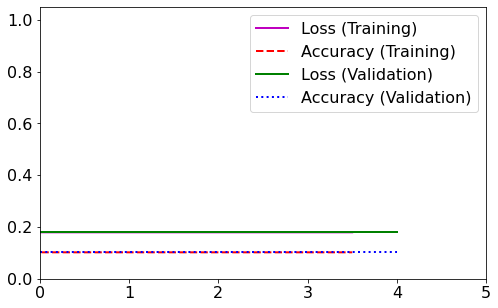

[Model0--Broken] Test loss: 0.18076, test accuracy: 9.620%


In [10]:
# evaluate
evaluate_model(name, model, eval_data)

### Now let's check if you fixed the issue!

[Model0--Fixed] Training Accuracy: 97.917%, Validation Accuracy: 95.800%


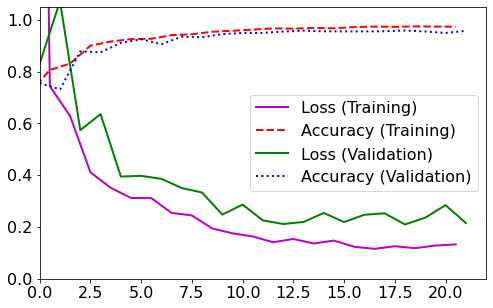

[Model0--Fixed] Test loss: 0.21144, test accuracy: 96.780%


In [11]:
## create and compile the model for fixed=True, train it, then evaluate it
fixed = True
name, model = create_compile_model0(fixed, verbose=False) 

# train
eval_data = train_model(model)

# evaluate
evaluate_model(name, model, eval_data)

### We see that the model works now; it achieves about 96% accuracy.

### [Task 2b] (5 points) Just like task 2a, consider the following model. It has one obvious problem which prevents the model from learning: can you figure out what it is? Fix it by adding code to the 'if fixed:'' branch. Make sure that if fixed=False you do not change the implementation!

### Note: the model is different in some ways to model0 but most of these ways are unrelated to the problem you are asked to diagnose and fix!

In [12]:
def create_compile_model1(fixed, input_shape=784, num_outputs=10, verbose=True):
    
    ###* Move the if fixed branch to where you want to use it, and create a corresponding else to preserve 
    ###* the broken functionality when fixed=False (if necessary)
    #if fixed:
        ###* put your code here (~1-2 lines) *###

    name = 'Model1--Fixed' if fixed else 'Model1--Broken'
    hidden_widths=[256, 128, 48]
    
    model = keras.models.Sequential(name=name)
    
    model.add(keras.Input(shape=(input_shape,), sparse=False)) 
    
    for i, hw in enumerate(hidden_widths):
        model.add(keras.layers.Dense(hw, activation='relu', name='hidden_{}'.format(i), 
                                     kernel_initializer=keras.initializers.RandomNormal(stddev=np.sqrt(1/hw)),
                                     bias_initializer=keras.initializers.Zeros(), use_bias=False))
        
    model.add(keras.layers.Dense(num_outputs, activation='softmax', name='output',
                                kernel_initializer=keras.initializers.RandomNormal(stddev=np.sqrt(0.1)),
                                bias_initializer=keras.initializers.Zeros(), use_bias=True))
    
    opt = keras.optimizers.Adam(lr=0.025)
    
    if fixed:
        opt = keras.optimizers.Adam(lr=0.001)
    
    if verbose:
        model.summary()
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return name, model

In [13]:
## create and compile the model for fixed=False, train it, then evaluate it
fixed = False
name, model = create_compile_model1(fixed) 

# train the model (hint you can set verbose to 1 to get more information during the training process)
eval_data = train_model(model)

Model: "Model1--Broken"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_0 (Dense)             (None, 256)               200704    
_________________________________________________________________
hidden_1 (Dense)             (None, 128)               32768     
_________________________________________________________________
hidden_2 (Dense)             (None, 48)                6144      
_________________________________________________________________
output (Dense)               (None, 10)                490       
Total params: 240,106
Trainable params: 240,106
Non-trainable params: 0
_________________________________________________________________


[Model1--Broken] Training Accuracy: 73.358%, Validation Accuracy: 72.560%


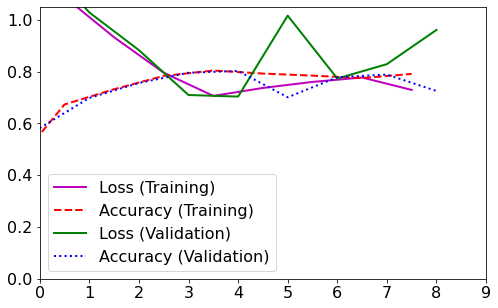

[Model1--Broken] Test loss: 0.98385, test accuracy: 72.920%


In [14]:
# evaluate
evaluate_model(name, model, eval_data)

### [Task 2c] (5 points) Explain what was the problem. (A sentence or two is fine.)

In [15]:
###* put your answer here *###
#
# The learning rate was too high which causes the process to diverge.
#

### Let's check if you fixed the issue.

In [ ]:
name, model = create_compile_model1(True, verbose=False) 

eval_data = train_model(model)
evaluate_model(name, model, eval_data)

### [Task 2d] (5 points) Just like task 2a and task 2b, consider the following model. It has one obvious problem which prevents the model from learning: can you figure out what it is? Fix it by adding code to the 'if fixed:'' branch. Make sure that if fixed=False you do not change the implementation!

In [17]:
def create_compile_model2(fixed, input_shape=784, num_outputs=10, verbose=True):
    
    ###* Move the if fixed branch to where you want to use it, and create a corresponding else to preserve 
    ###* the broken functionality when fixed=False (if necessary)
    #if fixed:
        ###* put your code here (~1-2 lines) *###
    
    name = 'Model2--Fixed' if fixed else 'Model2--Broken'
    hidden_widths=[400, 96]
    
    model = keras.models.Sequential(name=name)
    
    model.add(keras.Input(shape=(input_shape,), sparse=False)) 
    
    for i, hw in enumerate(hidden_widths):
        model.add(keras.layers.Dense(hw, activation='relu', name='hidden_{}'.format(i), 
                                     use_bias=True))
        
    model.add(keras.layers.Dense(num_outputs, activation='softmax', name='output', use_bias=False))
    
    opt = keras.optimizers.RMSprop(lr=1e-7)
    if fixed:
        opt = keras.optimizers.RMSprop(lr=0.0005)
    
    if verbose:
        model.summary()
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return name, model

In [18]:
# create and compile the model for fixed=False, train it, then evaluate it
name, model = create_compile_model2(False) 

# train the model (hint you can set verbose to 1 to get more information during the training process)
eval_data = train_model(model)

Model: "Model2--Broken"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_0 (Dense)             (None, 400)               314000    
_________________________________________________________________
hidden_1 (Dense)             (None, 96)                38496     
_________________________________________________________________
output (Dense)               (None, 10)                960       
Total params: 353,456
Trainable params: 353,456
Non-trainable params: 0
_________________________________________________________________


[Model2--Broken] Training Accuracy: 25.900%, Validation Accuracy: 26.000%


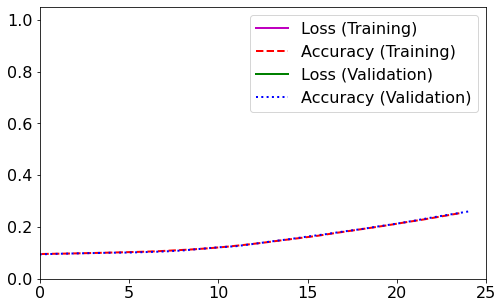

[Model2--Broken] Test loss: 42.78197, test accuracy: 26.260%


In [19]:
# evaluate
evaluate_model(name, model, eval_data)

### [Task 2e] (5 points) Explain what was the problem. (A sentence or two is fine.)

In [20]:
###* put your answer here *###
#
# The learning rate was too small which made the training process not converge in the maximum number of epochs.
#

### Let's check if you fixed the issue.

[Model2--Fixed] Training Accuracy: 99.348%, Validation Accuracy: 97.480%


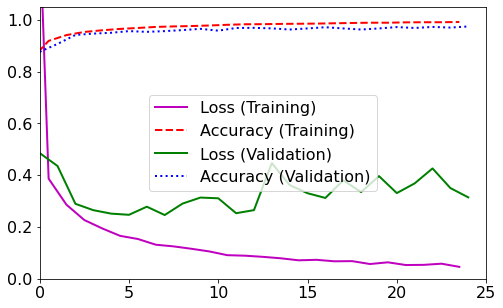

[Model2--Fixed] Test loss: 0.42831, test accuracy: 97.280%


In [21]:
name, model = create_compile_model2(True, verbose=False) 

eval_data = train_model(model)
evaluate_model(name, model, eval_data)

## [Task 3] (30 points) Diagnosing Other Problems

### [Task 3a] (5 points) Just like in task 2, consider the following model. It has one obvious problem which prevents the model from learning: can you figure out what it is? Fix it by adding code to the 'if fixed:'' branch. Make sure that if fixed=False you do not change the implementation!

In [22]:
def create_compile_model3(fixed, input_shape=784, num_outputs=10, verbose=True):
    
    ###* Move the if fixed branch to where you want to use it, and create a corresponding else to preserve 
    ###* the broken functionality when fixed=False (if necessary)
    #if fixed:
        ###* put your code here (~1-2 lines) *###
    
    name = 'Model3--Fixed' if fixed else 'Model3--Broken'
    hidden_widths=[512, 128, 32, 24]
    
    model = keras.models.Sequential(name=name)
    
    model.add(keras.Input(shape=(input_shape,), sparse=False)) 
    
    for i, hw in enumerate(hidden_widths):
        model.add(keras.layers.Dense(hw, activation='relu', name='hidden_{}'.format(i), 
                                     bias_initializer=keras.initializers.RandomNormal(stddev=0.001), use_bias=True))
        
    if fixed:
        model.add(keras.layers.Dense(num_outputs, activation='softmax', name='output',
                                kernel_initializer=keras.initializers.RandomNormal(stddev=np.sqrt(0.1)),
                                bias_initializer=keras.initializers.Zeros(), use_bias=True))
    else:
        model.add(keras.layers.Dense(num_outputs, activation='tanh', name='output',
                                kernel_initializer=keras.initializers.RandomNormal(stddev=np.sqrt(0.1)),
                                bias_initializer=keras.initializers.Zeros(), use_bias=True))

    
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.995, epsilon=1e-07, amsgrad=False)
    
    if verbose:
        model.summary()
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return name, model

In [23]:
# create and compile the model for fixed=False, train it, then evaluate it
name, model = create_compile_model3(False) 

# train the model (hint you can set verbose get more or less information during the training process)
eval_data = train_model(model, verbose=1)

Model: "Model3--Broken"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_0 (Dense)             (None, 512)               401920    
_________________________________________________________________
hidden_1 (Dense)             (None, 128)               65664     
_________________________________________________________________
hidden_2 (Dense)             (None, 32)                4128      
_________________________________________________________________
hidden_3 (Dense)             (None, 24)                792       
_________________________________________________________________
output (Dense)               (None, 10)                250       
Total params: 472,754
Trainable params: 472,754
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
600/600 [==============================] - 3s 4ms/step - loss: nan - accuracy: 0.0984 - val_loss: nan

[Model3--Broken] Training Accuracy: 9.853%, Validation Accuracy: 10.140%


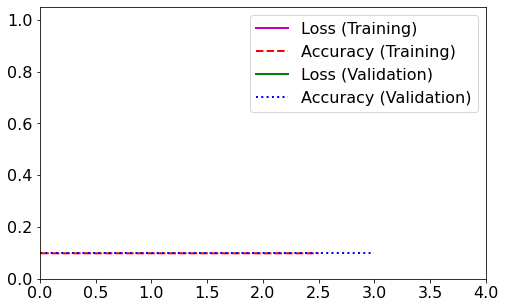

[Model3--Broken] Test loss: nan, test accuracy: 9.680%


In [24]:
# evaluate
evaluate_model(name, model, eval_data)

### [Task 3b] (5 points) Explain what was the problem. (A sentence or two is fine.)

In [25]:
###* put your answer here *###
#
# The activation function of the output layer is tanh which will cause some issues
#

### Let's check if you fixed the issue.

[Model3--Fixed] Training Accuracy: 99.622%, Validation Accuracy: 97.620%


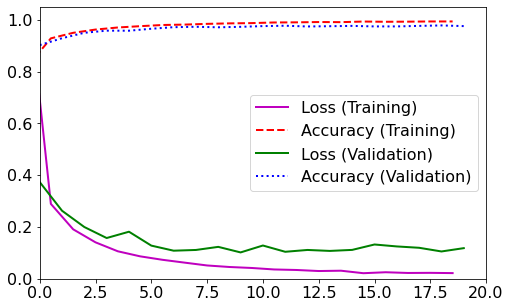

[Model3--Fixed] Test loss: 0.11040, test accuracy: 98.000%


In [26]:
name, model = create_compile_model3(True, verbose=False) 

eval_data = train_model(model)
evaluate_model(name, model, eval_data)

### [Task 3c] (5 points) Consider the following model. It has one obvious problem which prevents the model from learning: can you figure out what it is? Fix it by adding code to the 'if fixed:'' branch. Make sure that if fixed=False you do not change the implementation!

In [27]:
def create_compile_model4(fixed, input_shape=784, num_outputs=10, verbose=True):
    
    ###* Move the if fixed branch to where you want to use it, and create a corresponding else to preserve 
    ###* the broken functionality when fixed=False (if necessary)
    #if fixed:
        ###* put your code here (~1-2 lines) *###
    
    name = 'Model4--Fixed' if fixed else 'Model4--Broken'
    hidden_widths=[512, 128, 3, 24]
    if fixed:
        hidden_widths=[512, 128, 48, 24]
    
    model = keras.models.Sequential(name=name)
    
    model.add(keras.Input(shape=(input_shape,), sparse=False)) 
    
    for i, hw in enumerate(hidden_widths):
        model.add(keras.layers.Dense(hw, activation='relu', name='hidden_{}'.format(i)))
        
    
    model.add(keras.layers.Dense(num_outputs, activation='softmax', name='output',
                                kernel_initializer=keras.initializers.RandomNormal(stddev=np.sqrt(0.1)),
                                bias_initializer=keras.initializers.Zeros(), use_bias=True))
    
    opt = keras.optimizers.Nadam(lr=0.001)
    
    if verbose:
        model.summary()
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return name, model

In [28]:
# create and compile the model for fixed=False, train it, then evaluate it
name, model = create_compile_model4(False) 

# train the model (hint you can set verbose get more or less information during the training process)
eval_data = train_model(model, verbose=1)

Model: "Model4--Broken"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_0 (Dense)             (None, 512)               401920    
_________________________________________________________________
hidden_1 (Dense)             (None, 128)               65664     
_________________________________________________________________
hidden_2 (Dense)             (None, 3)                 387       
_________________________________________________________________
hidden_3 (Dense)             (None, 24)                96        
_________________________________________________________________
output (Dense)               (None, 10)                250       
Total params: 468,317
Trainable params: 468,317
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
600/600 [==============================] - 4s 6ms/step - loss: 3.0220 - accuracy: 0.1107 - val_loss: 

[Model4--Broken] Training Accuracy: 11.235%, Validation Accuracy: 11.920%


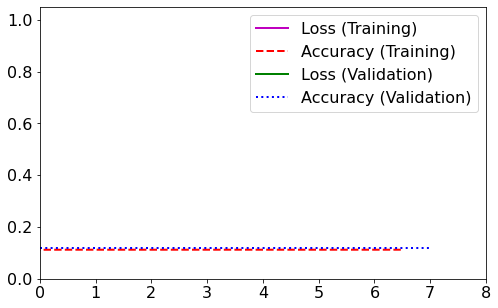

[Model4--Broken] Test loss: 2.30111, test accuracy: 10.800%


In [29]:
# evaluate
evaluate_model(name, model, eval_data)

### [Task 3d] (5 points) Explain what was the problem. (A sentence or two is fine.)

In [30]:
###* put your answer here *###
#
# There was a bottleneck layer with only 3 units. Obviously that's a bad idea, especially when you have 10 classes.
#

### Let's check if you fixed the issue.

[Model4--Fixed] Training Accuracy: 99.503%, Validation Accuracy: 97.380%


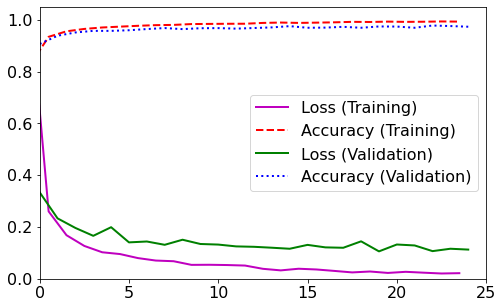

[Model4--Fixed] Test loss: 0.13562, test accuracy: 97.680%


In [31]:
name, model = create_compile_model4(True, verbose=False) 

eval_data = train_model(model)
evaluate_model(name, model, eval_data)

### [Task 3e] (5 points) Consider the following model. It has several problems which prevent it from learning: can you figure out what those problems are? Fix them by adding code to the 'if fixed:'' branch. Make sure that if fixed=False you do not change the implementation! You can have more than one "if fixed:" branch if necessary.

In [32]:
def create_compile_model5(fixed, input_shape=784, num_outputs=10, verbose=True):
    
    ###* Move the if fixed branch to where you want to use it, and create a corresponding else to preserve 
    ###* the broken functionality when fixed=False (if necessary)
    #if fixed:
        ###* put your code here (~1-2 lines) *###

    
    name = 'Model5--Fixed' if fixed else 'Model5--Broken'
    hidden_widths=[256, 128, 24]
    
    model = keras.models.Sequential(name=name)
    
    model.add(keras.Input(shape=(input_shape,))) 
    
    for i, hw in enumerate(hidden_widths):
        if fixed:
            model.add(keras.layers.Dense(hw, activation='relu', name='hidden_{}'.format(i)))
        else:
            model.add(keras.layers.Dense(hw, activation='sigmoid', name='hidden_{}'.format(i)))
        
    if fixed:
        model.add(keras.layers.Dense(num_outputs, activation='softmax', name='output'))
        
    else:
        model.add(keras.layers.Dense(num_outputs, activation='linear', name='output',
                                bias_initializer=keras.initializers.RandomNormal(stddev=np.sqrt(0.1)),
                                kernel_initializer=keras.initializers.Zeros(), use_bias=False))
                  
    
    opt = keras.optimizers.Nadam(lr=0.01, beta_2=0.999, epsilon=1e-07, clipvalue=1.0)
    if fixed:
        opt = keras.optimizers.Nadam(lr=0.001, beta_2=0.999, epsilon=1e-07, clipvalue=1.0)
    
    if verbose:
        model.summary()
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return name, model

In [33]:
# create and compile the model for fixed=False, train it, then evaluate it
name, model = create_compile_model5(False) 

# train the model (hint you can set verbose get more or less information during the training process)
eval_data = train_model(model, verbose=0)

Model: "Model5--Broken"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_0 (Dense)             (None, 256)               200960    
_________________________________________________________________
hidden_1 (Dense)             (None, 128)               32896     
_________________________________________________________________
hidden_2 (Dense)             (None, 24)                3096      
_________________________________________________________________
output (Dense)               (None, 10)                240       
Total params: 237,192
Trainable params: 237,192
Non-trainable params: 0
_________________________________________________________________


[Model5--Broken] Training Accuracy: 9.853%, Validation Accuracy: 10.140%


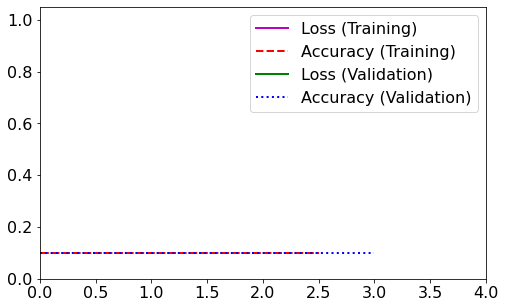

[Model5--Broken] Test loss: nan, test accuracy: 9.680%


In [34]:
# evaluate
evaluate_model(name, model, eval_data)

### [Task 3f] (5 points) Explain what was the problem. (A sentence or two is fine.)

In [35]:
###* put your answer here *###
#
# There are three issues:
# 1. we have to change activation functions of hidden layers and output layers 
    ## (note: for hidden layers the change is not critical but you would get only about 94% accuracy with tanh)
# 2. the weights for some layers were intialized to zeros
# 3. the learning rate is too high
#

### Let's check if you fixed the issue.

[Model5--Fixed] Training Accuracy: 99.275%, Validation Accuracy: 97.220%


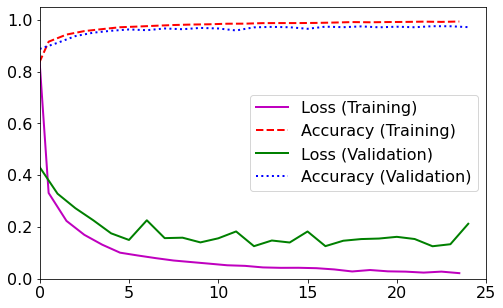

[Model5--Fixed] Test loss: 0.14309, test accuracy: 97.580%


In [36]:
name, model = create_compile_model5(True, verbose=False) 

eval_data = train_model(model)
evaluate_model(name, model, eval_data)

## [Task 4] (30 points) Training CNNs

### In this task, you will train a convolutional neural network with an architecture you define. The goal is (of course) to train the best possible model, but the constraint is that the number of parameters must not exceed 500k (500,000). We will aim to achieve test/val accuracy above 98.5%.

### If you do this on a machine with a GPU, it will be very fast. Otherwise it may take 5 or 10 minutes to train the model for a few epochs, so we will use a subset of the training data for developing and testing the model.

#### Note: it is possible to achieve reasonably high accuracy (above 98.5%) with only about 50k parameters.

### To use a convolutional architecture we need to reshape the data

In [37]:
use_subset = True
tr_sz = 5000

use_subset = False # uncomment this line to use the full data

# reshape for use with CNN
train_x = train_x.reshape(-1, 28, 28, 1)
val_x = val_x.reshape(-1, 28, 28, 1)
test_x = test_x.reshape(-1, 28, 28, 1)

cnn_dataset = (train_x, train_y, val_x, val_y, test_x, test_y)
if use_subset:
    cnn_dataset=(train_x[:tr_sz], train_y[:tr_sz], val_x, val_y, test_x, test_y)

### [Task 4a] (15 points) Fill in the implementation of create_compile_cnn() below with your chosen architecture. Ensure the total number of parameters chosen does not exceed 500k. You can look for insipiration for architectures on the web (or in books) if you like, but in that case you must provide a reference.

In [38]:
def create_compile_cnn(input_shape=(28, 28, 1), num_outputs=10, verbose=False):
    name = 'CNN'
    assert train_x.shape[1:] == input_shape # sanity check
    
    model = keras.models.Sequential(name=name)
    
    ### You can use any architecture but the output layer (with softmax activation is fixed). 
    ### You can also use whatever optimizer 'opt' you want (with your choice hyperparameters values)
    ### But the call to model.summary() must show that the number of parameters is within the constraint
    ### Note: you can import layers from keras.layers to make the code more compact.
    ###* put your code here (~10-20 lines) *###

    # The architecture below is based on LeNet-5
    from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
    
    filters_conv1 = 6
    model.add(Conv2D(filters_conv1, kernel_size=(5,5), input_shape=input_shape,
                     padding='same', activation='tanh', name='conv1'))
    model.add(MaxPooling2D(name='maxpool1')) # as "sampling" layer1
    
    filters_conv2 = 16
    model.add(Conv2D(filters_conv2, kernel_size=(5,5), activation='tanh', padding='valid', name='conv2'))
    model.add(MaxPooling2D(name='maxpool2')) # as "sampling" layer2
    
    # note: we need to flatten things so we can have some fully-connected layers afterwards
    model.add(Flatten(name='flatten'))
    
    model.add(Dense(120, activation='tanh', name='fc1'))
    model.add(Dense(84, activation='tanh', name='fc2'))
    
    model.add(Dense(num_outputs, activation="softmax", name='output'))
    
    opt = keras.optimizers.Adam(lr=0.001)
    
    if verbose:
        model.summary()
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return name, model

In [39]:
name, cnn_model = create_compile_cnn(verbose=True)

# note: you can change the number of epochs to train as long as it's reasonable
epochs = 30 if use_subset else 15
    
# note: you can change how you call train_model as necessary (e.g., if you want to change the batch_size)
eval_data = train_model(cnn_model, max_epochs=epochs, dataset=cnn_dataset, verbose=1)

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 28, 28, 6)         156       
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 14, 14, 6)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 10, 10, 16)        2416      
_________________________________________________________________
maxpool2 (MaxPooling2D)      (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
fc1 (Dense)                  (None, 120)               48120     
_________________________________________________________________
fc2 (Dense)                  (None, 84)                10164   

#### Let's evaluate your CNN model. Does it achieve 98.5+% val/test accuracy?
#### *note: once you are confident in your model architecture, you MUST switch back to the full dataset*
#### to train the final version of the model (depending on your chosen architecture this could take 10-15 minutes if you are not on machine with GPU)

[CNN] Training Accuracy: 99.690%, Validation Accuracy: 98.720%


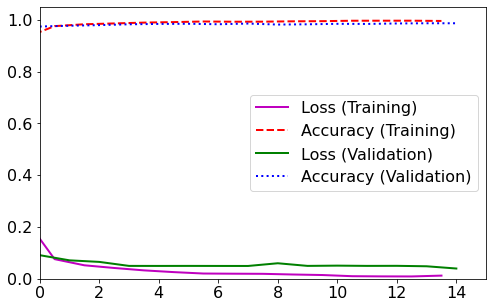

[CNN] Test loss: 0.04949, test accuracy: 98.560%


In [40]:
evaluate_model(name, cnn_model, eval_data)

### [Task 4b] (5 points) How long (in seconds/minutes) did your model take to train on the full dataset? Did you use a GPU?

In [41]:
###* put your answer here *###
#
# It took about 12 seconds per epochs and trained for 15 epochs so about 3 minutes total. 
# I did not use a GPU as this machine doesn't have one. (I could have used HiPerGator to speed things up.)
#

### [Task 4c] (10 points) Explain how you decided on this architecture. (2-3 sentences is okay.) If you took inspiration from resources such as books/webpages, it's okay but you should include a reference in your answer.

In [42]:
###* put your answer here *###
#
# The architecture used here is based on 'LeNet-5' (Google it to find more details) which has 7 layers:
# 3 of which are convolutional, 2 are sampling layers, and the rest (2) are fully-connected.
# The number of parameters of this architecture is only 62k. With a bigger network, it would of course be easy to achieve even higher accuracy.
#
# A thing to note about this architecture is that it uses tanh for activation of the convolutional and fully connected layers 
# (but the output layer is softmax, of course). Also, for this implementation we used maxpooling for the sampling layers.
#
# Ref: original paper by LeCun et al. http://www.iro.umontreal.ca/~lisa/bib/pub_subject/language/pointeurs/lecun-01a.pdf
# Figure 2 shows the architecture
#

## [CIS6930 Additional Task -- Task 5] (25 points): CNN vs. Data Augmentation

### In this task we want to understand the impact of data augmentation on model quality. We pretend that we only have access to 2k examples from the MNIST training set and then multiply its size (by 5X) using data augmentation.

### The idea is to compare the performance of three models (all of which using your CNN architecture from Task 4): (1) the CNN trained on tr_x, ty_y (2k examples), (2) the CNN trained on the augmented data (10k examples), and (3) the CNN trained on 10k examples from the MNIST training set.

### [Task 5a] (15 points) Complete the code below to use data augmentation to produce a dataset of size 'data_aug_sz' from the tr_x and tr_y. You can use tf.keras' ImageDataGenerator with parameters chosen by you. 

In [43]:
from keras.preprocessing.image import ImageDataGenerator

# dataset 1 -- 2k examples from mnist
tr_sz = 2000
cnn_dataset1 = (train_x[:tr_sz], train_y[:tr_sz], val_x, val_y, test_x, test_y)

# dataset 2 -- data augmentation (10k) starting from 2k examples from mnist
tr_x = train_x[:tr_sz]
tr_y = train_y[:tr_sz]

data_aug_sz = 10000

### Note: you will want to look very closely at the documentation of ImageDataGenerator (https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)
### in order to make sure you do not do strange things (e.g., it might not be a good idea to have vertical_flip=True, etc.)...
### Store the augmented data into aug_tr_x and aug_tr_y
###* put your code here (~5-10 lines) *###

aug_data_gen = ImageDataGenerator(featurewise_center=False, samplewise_center=False, 
                                  featurewise_std_normalization=False, samplewise_std_normalization=False,
                                  zca_whitening=False, horizontal_flip=False, vertical_flip=False,
                                  # this will randomly rotate, zoom, and shift images.
                                  rotation_range=11, zoom_range = 0.125, width_shift_range=0.11, height_shift_range=0.08)

num_next_calls = int(data_aug_sz / tr_sz)
aug_tr_iter = aug_data_gen.flow(tr_x, tr_y, batch_size=tr_sz)

x1, y1 = aug_tr_iter.next()
aug_tr_x = x1
aug_tr_y = y1

for i in range(1, num_next_calls):
    xi, yi = aug_tr_iter.next()

    aug_tr_x = np.r_[aug_tr_x, xi]
    aug_tr_y = np.r_[aug_tr_y, yi]
    


# store the result
cnn_dataset2 = (aug_tr_x, aug_tr_y, val_x, val_y, test_x, test_y)
assert aug_tr_x.shape[0] == data_aug_sz and aug_tr_y.shape[0] == data_aug_sz

# dataset 3 -- 10k examples from mnist
cnn_dataset3 = (train_x[:data_aug_sz], train_y[:data_aug_sz], val_x, val_y, test_x, test_y)
assert aug_tr_x.shape == cnn_dataset3[0].shape


---------- Model 1 (train size: 2000) -----------
[CNN] Training Accuracy: 100.000%, Validation Accuracy: 93.840%


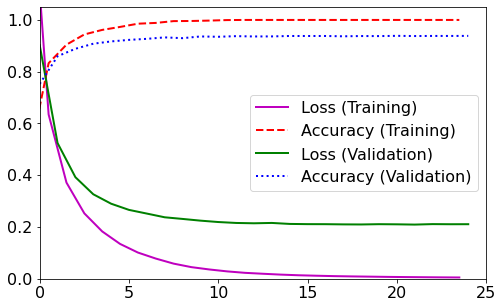

[CNN] Test loss: 0.20839, test accuracy: 93.720%

---------- Model 2 Data Augmented (train size: 10000) -----------
[CNN] Training Accuracy: 100.000%, Validation Accuracy: 96.120%


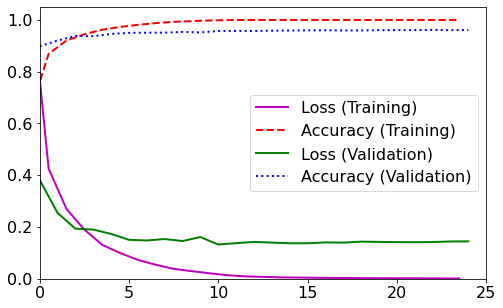

[CNN] Test loss: 0.14852, test accuracy: 95.940%

---------- Model 3 (train size: 10000) -----------
[CNN] Training Accuracy: 100.000%, Validation Accuracy: 96.780%


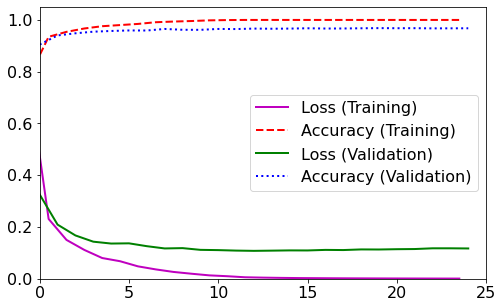

[CNN] Test loss: 0.11951, test accuracy: 96.900%


In [44]:
### Now let's evaluate all three models

datasets = (cnn_dataset1, cnn_dataset2, cnn_dataset3)
names = ['Model 1 (train size: {})'.format(tr_sz), 'Model 2 Data Augmented (train size: {})'.format(data_aug_sz),
         'Model 3 (train size: {})'.format(data_aug_sz)]

for i, dataset in enumerate(datasets):
    name, cnn_model = create_compile_cnn(verbose=False)

    # note: you can change how you call train_model as necessary (e.g., if you want to change the batch_size)
    eval_data = train_model(cnn_model, max_epochs=25, dataset=dataset, verbose=0)

    print('\n---------- {} -----------'.format(names[i]))
    evaluate_model(name, cnn_model, eval_data)

### [Task 5b] (10 points) What do you conclude about data augmentation? Does it help if you don't have enough data? Is it as good as having more real data? (A few sentences is fine.)

In [45]:
###* put your answer here *###
#
# We can see that data augmentation clearly helps (it yields almost 2% additional performance compared to training with the original dataset)
# However, we also see that having the same amount of real data points is much better (~about an additional 1% accuracy)
#